# highD (LevelX)

## About

The highD dataset was created and published by a team from the Institute for Automotive Engineering (ika) of RWTH Aachen University to promote research in many different domains of mobility. The dataset can therefore be downloaded and used free of charge for academic and research purposes.

This dataset includes post-processed trajectories of 110,500 vehicles including cars and trucks extracted from drone video recordings at German highways around Cologne during 2017 and 2018. At six different locations, 60 recordings were made with an average length of 17 minutes (16.5 h in total) covering a road segment of about 420 m length. Each vehicle is visible for a median duration of 13.6 s.

### How to Apply Dataset

The highD dataset is free for non-commercial use only. According to the license and protocols, as a third-party, we cannot share any form of this dataset online. Please visit [the official website](https://levelxdata.com/highd-dataset/) of highD, fill in the application form and send your request.

### How to Obtain Map

The maps of highD dataset are manually created by Tactics2D, in the format of OpenStreetMap (OSM), labeled in Lanelet2 style. The maps are stored in `data/highD_map`. You can download them from [here](https://github.com/WoodOxen/tactics2d/tree/master/tactics2d/data/highD_map)

### Citation

```latex
@inproceedings{highD,
    title={The highD Dataset: A Drone Dataset of Naturalistic Vehicle Trajectories on German Highways for Validation of Highly Automated Driving Systems},
    author={Krajewski, Robert and Bock, Julian and Kloeker, Laurent and Eckstein, Lutz},
    booktitle={2018 21st International Conference on Intelligent Transportation Systems (ITSC)},
    pages={2118-2125},
    year={2018},
    doi={10.1109/ITSC.2018.8569552}
}
```

## Data Analysis

> This part is independently conducted by Tactics2D.

According to meta records:

- Trajectory data files 01-03 are recorded in location 2 (denoted as highD_2)
- Trajectory data files 04-06 are recorded in location 3 (denoted as highD_3)
- Trajectory data files 07-10 are recorded in location 4 (denoted as highD_4)
- Trajectory data files 11-14, 25-57 are recorded in location 1 (denoted as highD_1)
- Trajectory data files 15-24 are recorded in location 5 (denoted as highD_5)
- Trajectory data files 58-60 are recorded in location 6 (denoted as highD_6)

![Locations of the recordings in highD](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/highD-locations.png)

In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig(level=logging.WARNING)

import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting up parameters for matplotlib
mpl.rcParams.update(
    {
        "figure.dpi": 200,  # 200 for high quality
        "font.family": "DejaVu Sans Mono",
        "font.size": 6,
        "font.stretch": "semi-expanded",
        "animation.html": "jshtml",
        "animation.embed_limit": 5000,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#cccccc",
        "axes.facecolor": "white",
    }
)
sns.set_palette("Set2")

In [3]:
locations = dict()
dfs_meta = pd.DataFrame()
for i in range(1, 61):
    df_meta = pd.read_csv("../../data/highD/data/%02d_recordingMeta.csv" % i)
    locations[i] = df_meta["locationId"][0]
    dfs_meta = pd.concat([dfs_meta, df_meta], ignore_index=True)

In [4]:
dfs_track_meta = pd.DataFrame()
for i in range(1, 61):
    df_track_meta = pd.read_csv("../../data/highD/data/%02d_tracksMeta.csv" % i)
    df_track_meta["locationId"] = locations[i]
    df_track_meta["fileId"] = i
    dfs_track_meta = pd.concat([dfs_track_meta, df_track_meta], ignore_index=True)

### Distribution of Trajectory Categories

There are two types of vehicles in the highD dataset: `Car` and `Truck`. The composition of vehicle types varies significantly across locations, and within each location, the proportion of each vehicle type exhibits noticeable variance. Nevertheless, `Car` consistently accounts for over 70% of all vehicles, regardless of location.

In [5]:
dfs_meta["car_ratio"] = dfs_meta["numCars"] / dfs_meta["numVehicles"]
dfs_meta["locationId"] = pd.Categorical(
    dfs_meta["locationId"], categories=[1, 2, 3, 4, 5, 6], ordered=True
)

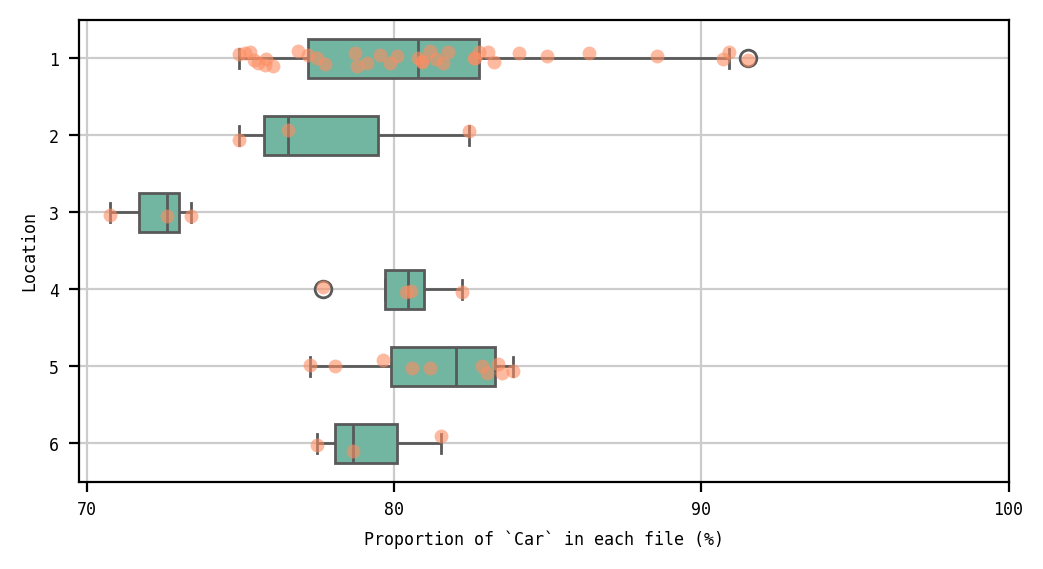

In [6]:
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(data=dfs_meta, x="car_ratio", y="locationId", width=0.5, ax=ax)

sns.stripplot(data=dfs_meta, x="car_ratio", y="locationId", alpha=0.6, ax=ax)

ax.set_xticks([0.7, 0.8, 0.9, 1.0])
ax.set_xticklabels(["70", "80", "90", "100"])
ax.yaxis.grid(True)
ax.set_xlabel("Proportion of `Car` in each file (%)")
ax.set_ylabel("Location")
plt.show()

### Distribution of X-Velocity

X-Velocity refers to the vehicles' speed along the direction of the route. In this visualization, we present the distribution of the minimum, mean, and maximum X-Velocity for each trajectory, grouped by location. Despite being recorded on a highway, the X-Velocity varies significantly among individual drivers. Notably, the distribution shows multiple peaks: one around 23 m/s (approximately 80 km/h), and another around 33 m/s (approximately 120 km/h). However, without accurate mapping to real-world time, it is difficult to determine whether these peaks are caused by rush hour traffic patterns or simply reflect natural differences in driving behavior.

In [7]:
dfs_track_meta_melt_by_velocity = dfs_track_meta.melt(
    id_vars="locationId",
    value_vars=["minXVelocity", "maxXVelocity", "meanXVelocity"],
    var_name="XVelocity",
)

dfs_track_meta_melt_by_velocity["locationId"] = pd.Categorical(
    dfs_track_meta_melt_by_velocity["locationId"], categories=[1, 2, 3, 4, 5, 6], ordered=True
)

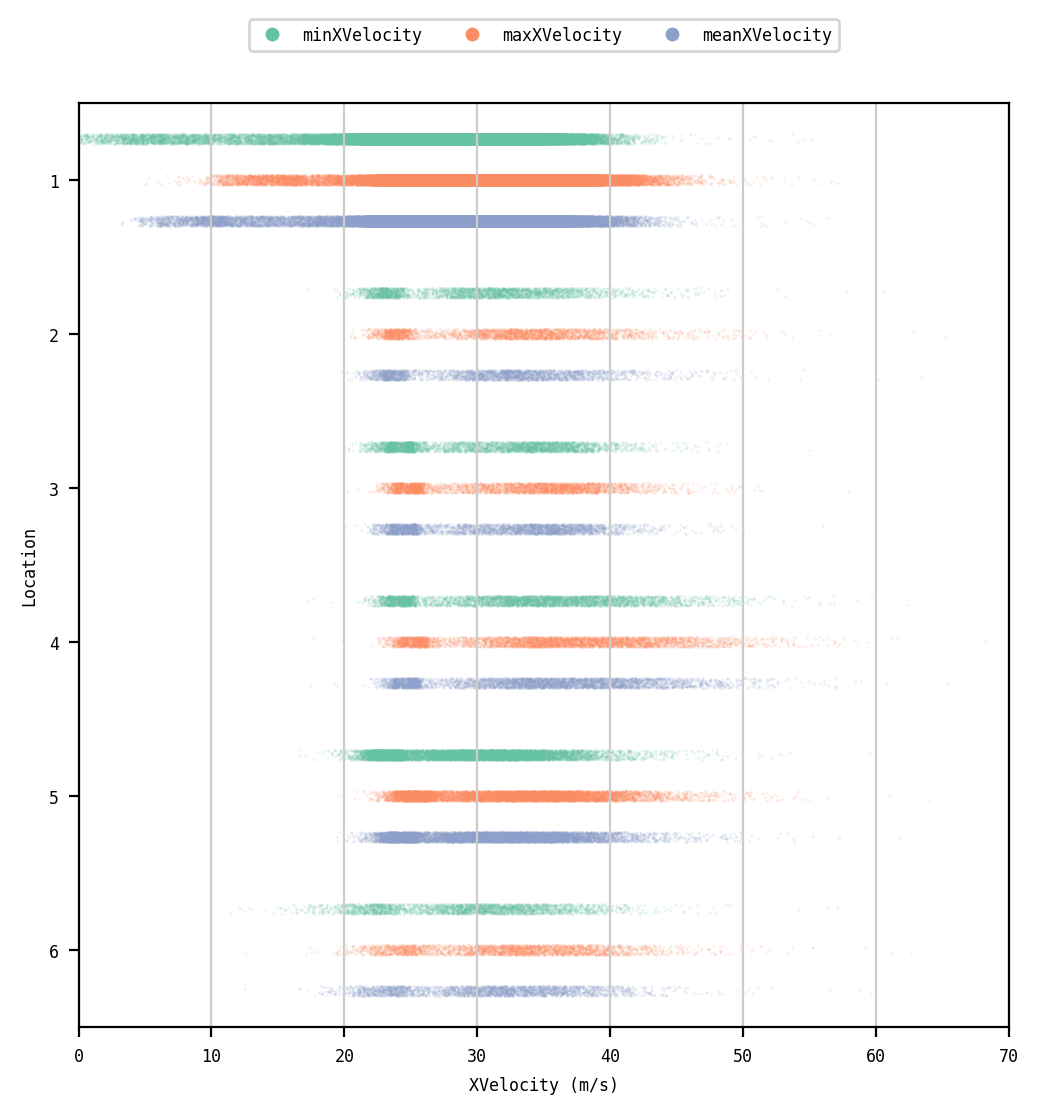

In [8]:
f, ax = plt.subplots(figsize=(6, 6))
sns.stripplot(
    data=dfs_track_meta_melt_by_velocity,
    x="value",
    y="locationId",
    hue="XVelocity",
    dodge=True,
    alpha=0.15,
    zorder=1,
    jitter=True,
    size=1,
    palette="Set2",
    ax=ax,
)

sns.move_legend(
    ax, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3, markerscale=5, title=None
)

legend = ax.get_legend()
for handle in legend.get_lines():
    handle.set_alpha(1)

ax.set_xlim(0, 70)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
ax.set_xticklabels(["0", "10", "20", "30", "40", "50", "60", "70"])
ax.set_xlabel("XVelocity (m/s)")
ax.set_ylabel("Location")
plt.show()

In [9]:
dfs = [pl.DataFrame()] * 6

for i in range(1, 61):
    df = pl.read_csv("../../data/highD/data/%02d_tracks.csv" % i)
    df = df.select(["id", "frame", "x", "y", "xVelocity", "yVelocity", "laneId"])
    df = df.with_columns(pl.lit(i).alias("fileId"))
    df = df.join(
        pl.DataFrame(dfs_track_meta)[["fileId", "id", "class"]], on=["fileId", "id"], how="left"
    )

    dfs[locations[i] - 1] = pl.concat([dfs[locations[i] - 1], df])

In [10]:
for i in range(6):
    x_min = np.floor(dfs[i]["x"].min())
    x_max = np.ceil(dfs[i]["x"].max())
    y_min = np.floor(dfs[i]["y"].min())
    y_max = np.ceil(dfs[i]["y"].max())
    vx = dfs[i]["xVelocity"].to_numpy()
    vy = dfs[i]["yVelocity"].to_numpy()

    x_edges_1 = np.linspace(x_min, x_max, num=int((x_max - x_min) * 10 + 1), endpoint=True)
    y_edges_1 = np.linspace(y_min, y_max, num=int((y_max - y_min) * 10 + 1), endpoint=True)
    x_bin_1 = np.digitize(dfs[i]["x"].to_numpy(), x_edges_1) - 1
    y_bin_1 = np.digitize(dfs[i]["y"].to_numpy(), y_edges_1) - 1
    x_edges_2 = np.linspace(x_min, x_max, num=int((x_max - x_min) * 2 + 1), endpoint=True)
    y_edges_2 = np.linspace(y_min, y_max, num=int((y_max - y_min) * 2 + 1), endpoint=True)
    x_bin_2 = np.digitize(dfs[i]["x"].to_numpy(), x_edges_2) - 1
    y_bin_2 = np.digitize(dfs[i]["y"].to_numpy(), y_edges_2) - 1
    speed = np.sqrt(vx**2 + vy**2)
    heading = np.arctan(vy / vx)

    dfs[i] = dfs[i].with_columns(
        [
            pl.Series("x_bin_1", x_bin_1),
            pl.Series("y_bin_1", y_bin_1),
            pl.Series("x_bin_2", x_bin_2),
            pl.Series("y_bin_2", y_bin_2),
            pl.Series("speed (m/s)", speed),
            pl.Series("heading (radian)", heading),
        ]
    )

### Distribution of Average Speed on Map

We present a heatmap of the average vehicle speed at each location. The tight clustering of data points suggests that vehicle positions have already been calibrated, and the variation across different files is negligible.

Notably, vehicles in the outer (leftmost) lanes tend to have lower average speeds compared to those in the inner (rightmost) lanes, which aligns with common traffic patterns. The average speed at some lanes exceeds 50 m/s (180 km/h), highlighting a distinctive feature of German highways, where no speed limit is enforced on certain sections.

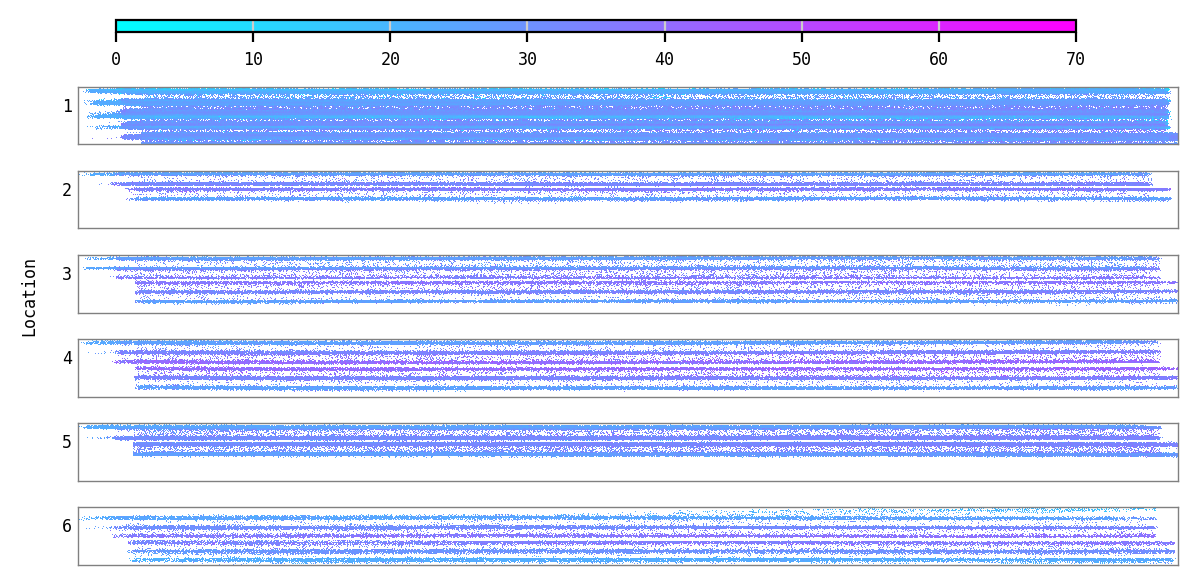

In [11]:
fig, axes = plt.subplots(6, 1, figsize=(6, 3), sharex=True, sharey=True)

for i in range(6):
    df_speed_heatmap = (
        dfs[i]
        .group_by(["y_bin_1", "x_bin_1"])
        .agg(pl.col("speed (m/s)").mean().alias("avg_speed"))
        .sort(["y_bin_1", "x_bin_1"])
    ).to_pandas()
    grid = df_speed_heatmap.pivot(index="y_bin_1", columns="x_bin_1", values="avg_speed")
    hm = sns.heatmap(
        grid,
        ax=axes[i],
        cmap="cool",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        vmin=0,
        vmax=70,
    )

    for spine in axes[i].spines.values():
        spine.set_visible(True)
        spine.set_color("gray")
        spine.set_linewidth(0.5)
    axes[i].set_aspect("equal")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(f"{i+1}", rotation=0)

cbar_ax = fig.add_axes([0.1, 0.94, 0.8, 0.02])
cbar = fig.colorbar(hm.get_children()[0], cax=cbar_ax, orientation="horizontal")
fig.text(0.02, 0.5, "Location", va="center", rotation="vertical")

plt.tight_layout(rect=[0.04, 0, 1, 0.9])
plt.show()

### Distribution of Lane Change Frequency on Map

The figure illustrates the cumulative count of lane-changing events within each predefined grid cell on the map. Lane changing events happen sporadically along the lanes, without showing a strong spatial pattern. This is likely because the data was collected on relatively stable highway segments, where vehicles generally follow consistent driving behavior and lane usage is less influenced by external factors such as intersections or merges.

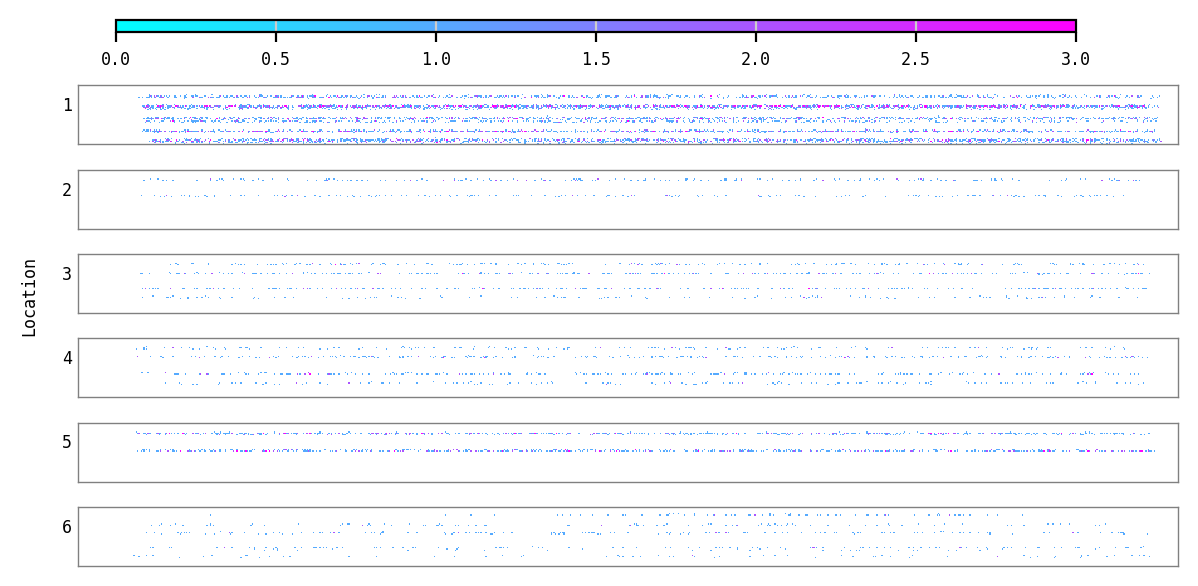

In [12]:
fig, axes = plt.subplots(6, 1, figsize=(6, 3), sharex=True, sharey=True)

for i in range(6):
    df_lane_changing = dfs[i].to_pandas()
    df_lane_changing = df_lane_changing.sort_values(by=["fileId", "id", "frame"])
    df_lane_changing["prev_laneId"] = df_lane_changing.groupby(["fileId", "id"])["laneId"].shift(1)
    df_lane_changing["laneChange"] = (
        df_lane_changing["laneId"] != df_lane_changing["prev_laneId"]
    ).astype(int)
    first_row_mask = df_lane_changing.groupby(["fileId", "id"]).cumcount() == 0
    df_lane_changing.loc[first_row_mask, "laneChange"] = 0
    df_lane_changing_heatmap = (
        df_lane_changing.groupby(["y_bin_2", "x_bin_2"])["laneChange"].sum().unstack(fill_value=0)
    )
    mask = df_lane_changing_heatmap == 0
    hm = sns.heatmap(
        df_lane_changing_heatmap,
        mask=mask,
        ax=axes[i],
        cmap="cool",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        vmin=0,
        vmax=3,
    )

    for spine in axes[i].spines.values():
        spine.set_visible(True)
        spine.set_color("gray")
        spine.set_linewidth(0.5)
    axes[i].set_aspect("equal")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(f"{i+1}", rotation=0)

cbar_ax = fig.add_axes([0.1, 0.94, 0.8, 0.02])
cbar = fig.colorbar(hm.get_children()[0], cax=cbar_ax, orientation="horizontal")
fig.text(0.02, 0.5, "Location", va="center", rotation="vertical")

plt.tight_layout(rect=[0.04, 0, 1, 0.9])
plt.show()

### Distribution of Speed by Vehicle Type

The speed distribution differs significantly between vehicle types. Vehicles of the same type tend to exhibit similar speed distribution patterns across different locations.

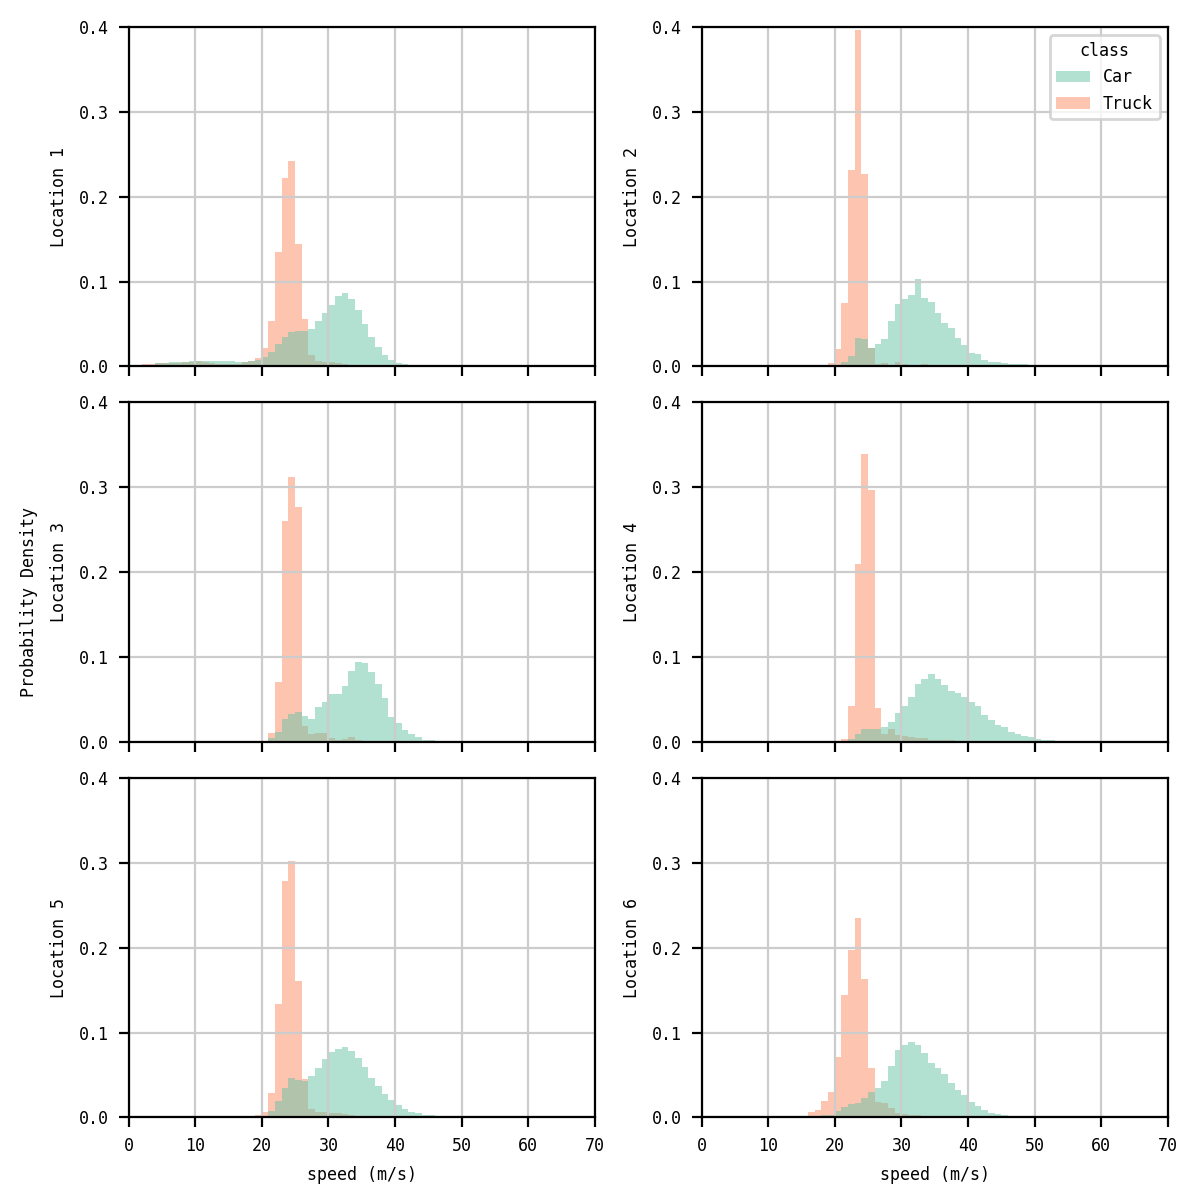

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(6, 6), sharex=True)
for i in range(6):
    df_speed = dfs[i].to_pandas()
    sns.histplot(
        df_speed,
        x="speed (m/s)",
        hue="class",
        hue_order=["Car", "Truck"],
        multiple="layer",
        palette="Set2",
        ax=axes[int(i // 2)][int(i % 2)],
        stat="density",
        common_norm=False,
        binwidth=1,
        binrange=(0, 70),
        linewidth=0,
        alpha=0.5,
        legend=(i == 1),
    )

    axes[int(i // 2)][int(i % 2)].set_xlim([0, 70])
    axes[int(i // 2)][int(i % 2)].set_ylabel(f"Location {i+1}")
    axes[int(i // 2)][int(i % 2)].set_ylim([0, 0.4])
    axes[int(i // 2)][int(i % 2)].set_yticks([0, 0.1, 0.2, 0.3, 0.4])

fig.text(0.02, 0.5, "Probability Density", va="center", rotation="vertical")

fig.tight_layout(rect=[0.03, 0, 1, 1])
plt.show()

### Distribution of Heading by Vehicle Type

We present a relative heading angle with respect to the direction of the route. The heading distribution of different types shows high similarity at each location. Since the scenario takes place on a highway, the heading does not deviate significantly from the route direction, with the jitter mostly kept within 0.02 radians.

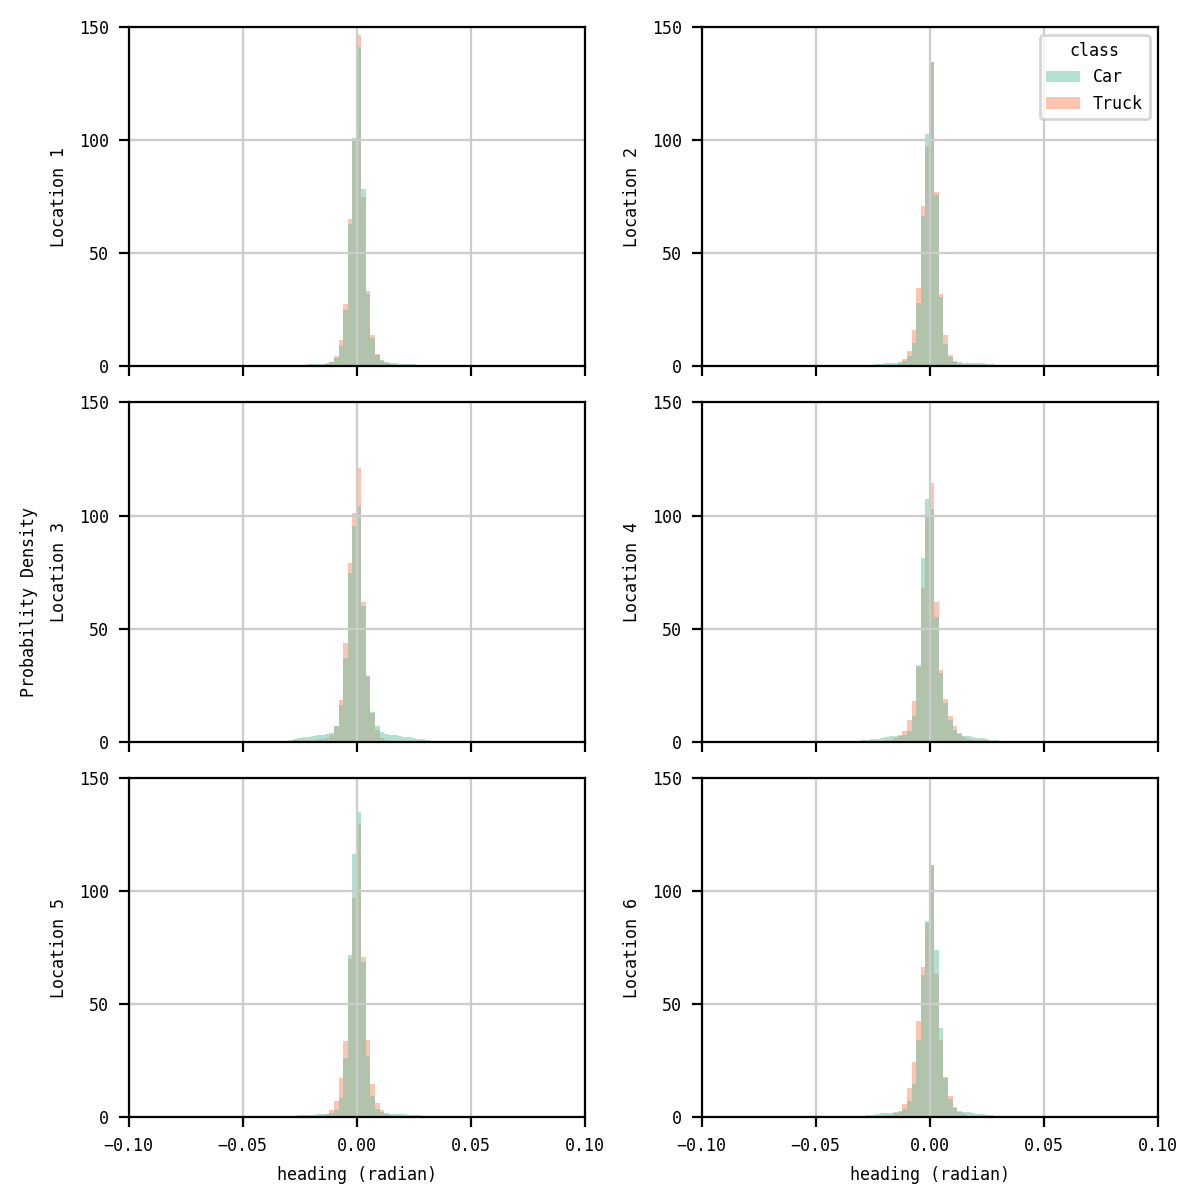

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(6, 6), sharex=True)
for i in range(6):
    df_heading = dfs[i].to_pandas()
    sns.histplot(
        df_heading,
        x="heading (radian)",
        hue="class",
        hue_order=["Car", "Truck"],
        multiple="layer",
        palette="Set2",
        ax=axes[int(i // 2)][int(i % 2)],
        stat="density",
        common_norm=False,
        binwidth=0.002,
        binrange=(-0.1, 0.1),
        linewidth=0,
        alpha=0.5,
        legend=(i == 1),
    )

    axes[int(i // 2)][int(i % 2)].set_xlim([-0.1, 0.1])
    axes[int(i // 2)][int(i % 2)].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
    axes[int(i // 2)][int(i % 2)].set_ylim([0, 150])
    axes[int(i // 2)][int(i % 2)].set_yticks([0, 50, 100, 150])
    axes[int(i // 2)][int(i % 2)].set_ylabel(f"Location {i+1}")

fig.text(0.02, 0.5, "Probability Density", va="center", rotation="vertical")

fig.tight_layout(rect=[0.03, 0, 1, 1])
plt.show()

## Tactics2D Integration

This section explains how to parse and replay logs from the highD dataset by Tactics2D.

### Dataset Preparation

You can place the highD dataset in any directory of your choice. However, it’s important to maintain the following folder structure for compatibility:

```shell
highD
├── data
│   ├── 01_highway.png
│   ├── 01_recordingMeta.csv
│   ├── 01_tracks.csv
│   ├── 01_tracksMeta.csv
│   ├── ...
```

### Class Mapping

The table below illustrates how classes from the highD dataset are mapped to corresponding traffic participants in the Tactics2D framework. In this mapping, both cars and trucks from highD are represented as the generic `Vehicle` class within Tactics2D.

| highD Class | Tactics2D Class |
|-------------|------------------|
| Car         | `tactics2d.participant.element.Vehicle` |
| Truck       | `tactics2d.participant.element.Vehicle` |

### Parse and Replay Logs

To parse, replay, and visualize the highD dataset using Tactics2D, you can use the following code snippet:

In [15]:
%matplotlib notebook

import os
import numpy as np
from matplotlib.animation import FuncAnimation
from shapely.geometry import Point
from IPython.display import HTML

from tactics2d.dataset_parser import LevelXParser
from tactics2d.map.parser import OSMParser
from tactics2d.map.map_config import HIGHD_MAP_CONFIG
from tactics2d.sensor import BEVCamera, MatplotlibRenderer

2025-07-03 14:54:32.661742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Specify the path to the dataset and the map, and then run the following code:

In [16]:
dataset_path = "../../data/highD/data"  # Replace with your dataset path
map_path = "../../data/highD_map"  # Replace with your map path
dataset_parser = LevelXParser("highD")
map_parser = OSMParser(lanelet2=True)

For simplicity, we revise a function from the `ScenarioManager` to handle the parsing and replaying of the highD dataset:

In [17]:
def render_levelx(map_, participants, map_boundary, stamp_range):
    x_min, x_max, y_min, y_max = map_boundary
    camera_position = np.array([0, 0])
    camera = BEVCamera(id_=0, map_=map_)

    renderer = MatplotlibRenderer(xlim=(x_min, x_max), ylim=(y_min, y_max), resolution=(2000, 800))

    fig = renderer.fig  # Use the one already created
    frame_list = list(range(stamp_range[0], stamp_range[1], 40))
    prev_road_id_set = set()
    prev_participant_id_set = set()

    def update(frame):
        nonlocal prev_road_id_set, prev_participant_id_set

        participant_ids = [pid for pid, p in participants.items() if p.is_active(frame)]

        geometry_data, prev_road_id_set, prev_participant_id_set = camera.update(
            frame,
            participants,
            participant_ids,
            prev_road_id_set,
            prev_participant_id_set,
            Point(camera_position),
        )

        renderer.update(geometry_data, camera_position)
        renderer.ax.set_title(f"Frame: {frame}")

    ani = FuncAnimation(fig, update, frames=frame_list, interval=40, repeat=True)
    return ani

In [18]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=11, folder=dataset_path, stamp_range=(0, 10000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "highD_1.osm"), configs=HIGHD_MAP_CONFIG["highD_1"]
)

print(f"Map boundary of HighD location 1: {map_.boundary}.")

boundary = (
    map_.boundary[0] + 100, map_.boundary[1] - 100,
    map_.boundary[2] - 20, map_.boundary[3] + 20
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range)
HTML(ani.to_html5_video())

Map boundary of HighD location 1: (-112.0, 558.0, -29.0, 0.0).


<IPython.core.display.Javascript object>

In the same way, we display the log in other locations in highD.

In [19]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=1, folder=dataset_path, stamp_range=(10000, 20000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "highD_2.osm"), configs=HIGHD_MAP_CONFIG["highD_2"]
)

print(f"Map boundary of HighD location 2: {map_.boundary}.")

boundary = (
    map_.boundary[0] + 100, map_.boundary[1] - 100,
    map_.boundary[2] - 20, map_.boundary[3] + 20
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range)
HTML(ani.to_html5_video())

Map boundary of HighD location 2: (-112.0, 558.0, -21.0, 0.0).


<IPython.core.display.Javascript object>

In [20]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=4, folder=dataset_path, stamp_range=(20000, 30000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "highD_3.osm"), configs=HIGHD_MAP_CONFIG["highD_3"]
)

print(f"Map boundary of HighD location 3: {map_.boundary}.")

boundary = (
    map_.boundary[0] + 100, map_.boundary[1] - 100,
    map_.boundary[2] - 20, map_.boundary[3] + 20
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range)
HTML(ani.to_html5_video())

Map boundary of HighD location 3: (-112.0, 558.0, -25.0, 0.0).


<IPython.core.display.Javascript object>

In [21]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=7, folder=dataset_path, stamp_range=(30000, 40000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "highD_4.osm"), configs=HIGHD_MAP_CONFIG["highD_4"]
)

print(f"Map boundary of HighD location 4: {map_.boundary}.")
boundary = (
    map_.boundary[0] + 100, map_.boundary[1] - 100,
    map_.boundary[2] - 20, map_.boundary[3] + 20
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range)
HTML(ani.to_html5_video())

Map boundary of HighD location 4: (-112.0, 558.0, -27.0, 0.0).


<IPython.core.display.Javascript object>

In [22]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=15, folder=dataset_path, stamp_range=(40000, 50000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "highD_5.osm"), configs=HIGHD_MAP_CONFIG["highD_5"]
)

print(f"Map boundary of HighD location 5: {map_.boundary}.")

boundary = (
    map_.boundary[0] + 100, map_.boundary[1] - 100,
    map_.boundary[2] - 20, map_.boundary[3] + 20
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range)
HTML(ani.to_html5_video())

Map boundary of HighD location 5: (-112.0, 558.0, -21.0, 0.0).


<IPython.core.display.Javascript object>

In [23]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=58, folder=dataset_path, stamp_range=(50000, 60000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "highD_6.osm"), configs=HIGHD_MAP_CONFIG["highD_6"]
)

print(f"Map boundary of HighD location 6: {map_.boundary}.")

boundary = (
    map_.boundary[0] + 100, map_.boundary[1] - 100,
    map_.boundary[2] - 20, map_.boundary[3] + 20
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range)
HTML(ani.to_html5_video())

Map boundary of HighD location 6: (-112.0, 558.0, -27.0, 4.0).


<IPython.core.display.Javascript object>

## Appendix: Data Format

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        This is a backup copy of 
        <a href="https://levelxdata.com/wp-content/uploads/2023/10/highD-Format.pdf" target="_blank" rel="noopener noreferrer">
            the official documentation
        </a>, provided here for reference purposes only.
    </p>
</div>

The highD dataset includes data extracted from 60 recordings. For each recording, in total four files are provided: 

- An image of the recorded highway section (XX_highway.jpg)
- A csv file describing the recording location (XX_recordingMeta.csv)
- A csv file containing an overview of recorded vehicle tracks (XX_tracksMeta.csv)
- A csv file for the tracks' trajectories. These files are created for each recording to ensure easy handling of the data. In the following, the dataset format and especially the meaning of every column is explained in detail. (XX_tracks.csv)

### Image of the Highway Section

For each recording an image of the highway section is added. The image was created from the used recording itself
by removing all vehicles through a filter. Additionally the resolution of the image was reduced.

### Recording Meta Information

This file contains metadata for each recording. The metadata provides a general overview, e.g. of the time of
recording, the highway section considered and the total number of vehicles recorded.

| Name | Description | Unit |
| --- | --- | --- |
| id | The id of the recording. Every recording has a unique id. | [-] |
| frameRate | The frame rate which was used to record the video. | [hz] |
| locationId | The id of the recording location. In total six different locations exist in the dataset. | [-] |
| speedLimit | The speed limit of the driving lanes. In all recordings, the speed limit is the same for every driving lane. | [m/s] |
| month | The month the recording was done. | [-] |
| weekDay | The week day the recording was done. | [-] |
| startTime | The start time at which the recording was done. | [hh:mm] |
| duration | The duration of the recording. | [s] |
| totalDrivenDistance | The total driven distance of all tracked vehicles. | [m] |
| totalDrivenTime | The total driven time of all tracked vehicles. | [s] |
| numVehicles | The number of vehicles tracked including cars and trucks. | [-] |
| numCars | The number of cars tracked. | [-] |
| numTrucks | The number of trucks tracked. | [-] |
| upperLaneMarkings | The y positions of the upper lane markings. The positions are separated by a ";". | [m] |
| lowerLaneMarkings | The y positions of the lower lane markings. The positions are separated by a ";". | [m] |

### Track Meta Information

This file contains an overview of all tracks. For each track there are summary values like the distance covered or the average speed. The purpose of this file is to allow to filter tracks e.g. by class or driving direction.

| Name | Description | Unit |
| --- | --- | --- |
| id | The id of the track. The ids are assigned in ascending order. | [-] |
| width | The width of the post-processed bounding box of the vehicle. This corresponds to the length of the vehicle. | [m] |
| height | The height of the post-processed bounding box of the vehicle. This corresponds to the width of the vehicle. | [m] |
| initialFrame | The initial frame in which the vehicle track starts. | [-] |
| finalFrame | The frame in which the track of the vehicle ends. | [-] |
| numFrames | The total lifetime of the track as number of frames. | [-] |
| class | The vehicle class of the tracked vehicle (Car or Truck). | [-] |
| drivingDirection | The driving direction of the vehicle. Either 1 for the left direction (upper lanes) or 2 for the right direction (lower lanes). | [-] |
| traveledDistance | The distance covered by the track. | [m] |
| minXVelocity | The minimal velocity in driving direction. | [m/s] |
| maxXVelocity | The maximal velocity in driving direction. | [m/s] |
| meanXVelocity | The mean velocity in driving direction. | [m/s] |
| minDHW | The minimal Distance Headway (DHW). This value is set to -1, if no preceding vehicle exists. | [m] |
| minTHW | The minimal Time Headway (THW). This value is set to -1, if no preceding vehicle exists. | [s] |
| minTTC | The minimal Time-to-Collision (TTC). This value is set to -1, if no preceding vehicle or valid TTC exists. | [s] |
| numLaneChanges | Number of lane changes detected by changing lane id. | [-] |

### Tracks

This file contains all time dependent values for each track. Information such as current velocities, viewing ranges and
information about surrounding vehicles are included.

| Name | Description | Unit |
| --- | --- | --- |
| frame | The current frame. | [-] |
| id | The track's id. | [-] |
| x | The x position of the upper left corner of the vehicle's bounding box. | [m] |
| y | The y position of the upper left corner of the vehicle's bounding box. | [m] |
| width | The width of the bounding box of the vehicle. | [m] |
| height | The height of the bounding box of the vehicle. | [m] |
| xVelocity | The longitudinal velocity in the image coordinate system. | [m/s] |
| yVelocity | The lateral velocity in the image coordinate system. | [m/s] |
| xAcceleration | The longitudinal acceleration in the image coordinate system. | [m/s²] |
| yAcceleration | The lateral acceleration in the image coordinate system | [m/s²] |
| frontSightDistance | The distance to the end of the recorded highway section in driving direction from the vehicle's center. | [m] |
| backSightDistance | The distance to the end of the recorded highway section in the opposite driving direction from the vehicle's center. | [m] |
| dhw | The Distance Headway. This value is set to 0, if no preceding vehicle exists. | [m] |
| thw | The Time Headway. This value is set to 0, if no preceding vehicle exists. | [s] |
| ttc | The Time-to-Collision. This value is set to 0, if no preceding vehicle or valid TTC exists. | [s] |
| precedingXVelocity | The longitudinal velocity of the preceding in the image coordinate system. This value is set to 0, if no preceding vehicle exists. | [-] |
| precedingId | The id of the preceding vehicle in the same lane. This value is set to 0, if no preceding vehicle exists. | [-] |
| followingId | The id of the following vehicle in the same lane. This value is set to 0, if no following vehicle exists. | [-] |
| leftPrecedingId | The id of the preceding vehicle on the adjacent lane on the left in the direction of travel. This value is set to 0, if no such a vehicle exists. | [-] |
| leftAlongsideId | The id of the adjacent vehicle on the adjacent lane on the left in the direction of travel. In order for a vehicle to be adjacent and not e.g. preceding, the vehicles must overlap in the longitudinal direction. This value is set to 0, if no such a vehicle exists. | [-] |
| leftFollowingId | The id of the following vehicle on the adjacent lane on the left in the direction of travel. This value is set to 0, if no such a vehicle exists. | [-] |
| rightPrecedingId | The id of the preceding vehicle on the adjacent lane on the right in the direction of travel. This value is set to 0, if no such a vehicle exists. | [-] |
| rightAlsongsideId | The id of the adjacent vehicle on the adjacent lane on the right in the direction of travel. In order for a vehicle to be adjacent and not e.g. preceding, the vehicles must overlap in the longitudinal direction. This value is set to 0, if no such a vehicle exists. | [-] |
| rightFollowingId | The id of the following vehicle on the adjacent lane on the right in the direction of travel. This value is set to 0, if no such a vehicle exists. | [-] |
| laneId | The IDs start at 1 and are assigned in ascending order. Since the Lane ids are derived from the positions of the lane markings, the first and last ids typically do not describe any useable lanes. For details, see the definition of the coordinate system. | [-] |

### Coordinate System

The global coordinate system used corresponds to the image coordinate system of the video recording. This means that the origin of the coordinate system is in the upper left corner, as shown in the image. The horizontal axis is the x-axis. This corresponds to the direction of travel of the vehicles and grows to the right. The vertical axis is the y-axis. However, this axis grows downwards. In addition no units in pixels are used, since all sizes were converted into SI units. The video recordings were stabilized so that the lane markings run horizontally in the image. Therefore, their positions can be indicated by a y-coordinate. The individual lanes were numbered starting with 1. The areas above the uppermost lane mark, between the driving directions and below the lowermost lane mark are also taken into account for counting. All data is given in the global coordinate system unless otherwise specified. This means that a vehicle on the upper lanes in the image is moving to the left and therefore has a negative speed in X direction.

![The coordinate system of highD dataset](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/highD-coordinate-system.png)